# MNIST Prediction with Artificial Neural Network

- MNIST dataset: is a dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images. More info can be found at the [MNIST homepage](http://yann.lecun.com/exdb/mnist/).
- Goal: build a simple artificial neural network to predict the digit in the images.

In [73]:
import keras
import numpy as np
import matplotlib.pyplot as plt

from keras import layers

from utils import get_activation_function, max_pooling

## 1. Utility Functions

In [74]:
def plot_data(X: np.ndarray, y: np.ndarray) -> None:
    nrows, ncols = 2, 4
    _, axes = plt.subplots(nrows, ncols, figsize=(8, 4))

    len_x = X.shape[0]
    for idx in range(nrows * ncols):
        ax = axes[idx // ncols, idx % ncols]

        img_idx = np.random.randint(0, len_x)

        ax.imshow(X[img_idx], cmap="gray")
        ax.set(xticks=[], yticks=[])

        true_label = f"True: {y[img_idx]}"
        ax.set_xlabel(true_label)

    plt.tight_layout()
    plt.show()

## 2. Load Data

In [75]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

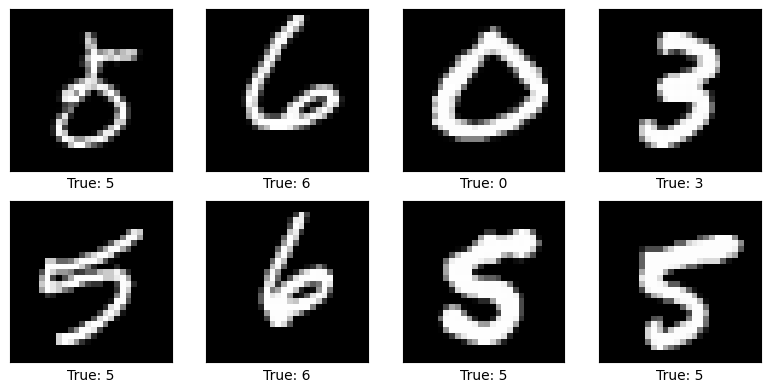

In [76]:
plot_data(X_train, y_train)

## 3. Image Preprocessing

In [77]:
# Convert to float32 and scale to [0, 1]
X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

In [78]:
# Add channel dimension
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

In [79]:
print("x_train shape:", X_train.shape)
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [80]:
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

## 4. Artificial Neural Network

### 4.1. With Convolutional Neural Network

#### 4.1.1. Model: Multi-Layer Perceptron

### 4.2 With Keras

In [81]:
inp_shape = X_train.shape[1:]

In [82]:
model = keras.models.Sequential(
    [
        layers.Flatten(input_shape=(28, 28)),
        layers.Dense(512, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dense(10, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_11 (Dense)             (None, 10)                2570      
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
_________________________________________________________________


In [83]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics="accuracy")

In [84]:
batch_size = 128
epochs = 15

history = model.fit(
    X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1
)

Epoch 1/15
422/422 [==============================] - 1s 2ms/step - loss: 0.4451 - accuracy: 0.8720 - val_loss: 0.1112 - val_accuracy: 0.9662
Epoch 2/15
422/422 [==============================] - 1s 1ms/step - loss: 0.0927 - accuracy: 0.9726 - val_loss: 0.0754 - val_accuracy: 0.9770
Epoch 3/15
422/422 [==============================] - 1s 2ms/step - loss: 0.0533 - accuracy: 0.9838 - val_loss: 0.0671 - val_accuracy: 0.9803
Epoch 4/15
422/422 [==============================] - 1s 2ms/step - loss: 0.0358 - accuracy: 0.9891 - val_loss: 0.0684 - val_accuracy: 0.9818
Epoch 5/15
422/422 [==============================] - 1s 2ms/step - loss: 0.0277 - accuracy: 0.9907 - val_loss: 0.0654 - val_accuracy: 0.9825
Epoch 6/15
422/422 [==============================] - 1s 2ms/step - loss: 0.0215 - accuracy: 0.9930 - val_loss: 0.0843 - val_accuracy: 0.9782
Epoch 7/15
422/422 [==============================] - 1s 2ms/step - loss: 0.0168 - accuracy: 0.9944 - val_loss: 0.0860 - val_accuracy: 0.9778
Epoch 

In [85]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.08520837128162384
Test accuracy: 0.9815999865531921


In [86]:
y_pred = model.predict(X_test)

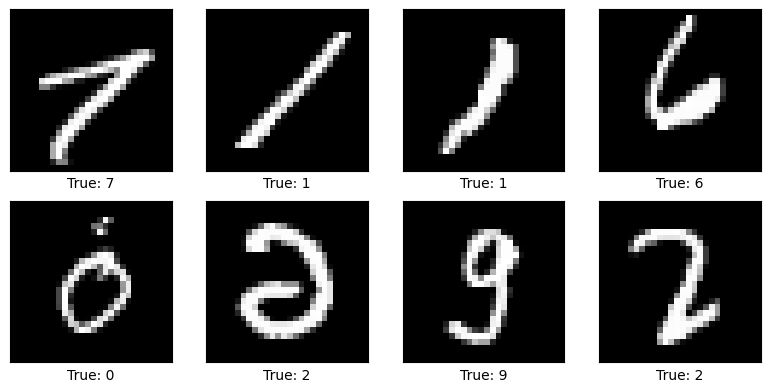

In [87]:
plot_data(X_test, np.argmax(y_pred, axis=1))

In [89]:
history_dict = history.history

In [90]:
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
train_loss, val_loss = history_dict["loss"], history_dict["val_loss"]
train_acc, val_acc = history_dict["accuracy"], history_dict["val_accuracy"]

TypeError: 'list' object cannot be interpreted as an integer

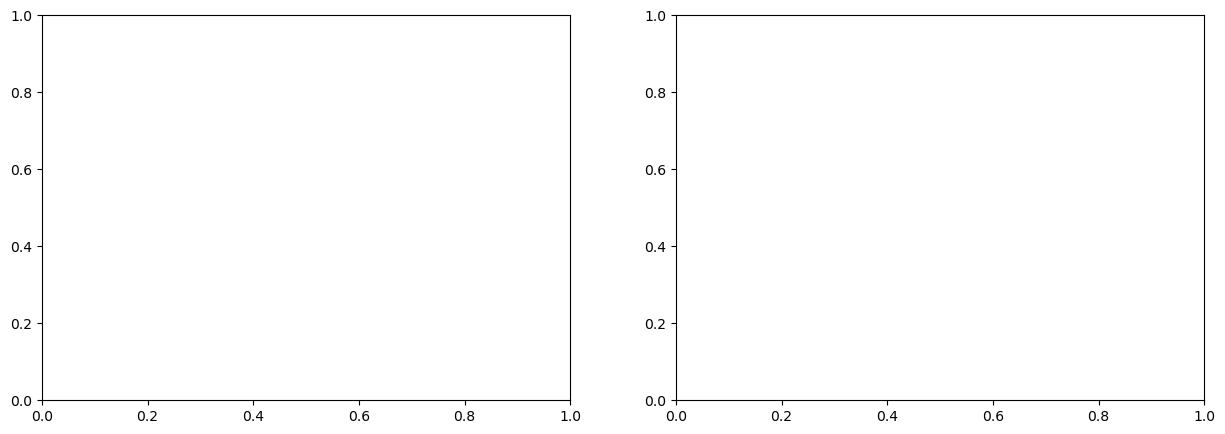

In [93]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
epochs = [i for i in range(epochs)]